# ZFNet Model Implementation - CIFAR-10
---

In [1]:
%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from collections import defaultdict
from matplotlib import pyplot as plt

import torch
import numpy as np

# Dataset and DataLoader

In [2]:
cifar10_dataset = datasets.CIFAR10(
    root='../dataset/CIFAR-10',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

imgs = [img for img, _ in cifar10_dataset]
imgs = torch.stack(imgs, dim=0).numpy()

cifar10_means = [
    imgs[:, 0, :, :].mean(),
    imgs[:, 1, :, :].mean(),
    imgs[:, 2, :, :].mean(),
]
cifar10_stds = [
    imgs[:, 0, :, :].std(),
    imgs[:, 1, :, :].std(),
    imgs[:, 2, :, :].std(),
]

print(imgs.shape)
print(cifar10_means, cifar10_stds)

Files already downloaded and verified
(50000, 3, 32, 32)
[0.49139968, 0.48215827, 0.44653124] [0.24703233, 0.24348505, 0.26158768]


In [3]:
img_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_means, std=cifar10_stds),
])

train_dataset = datasets.CIFAR10(
    root='../dataset/CIFAR-10',
    train=True,
    download=True,
    transform=img_transforms,
)

test_dataset = datasets.CIFAR10(
    root='../dataset/CIFAR-10',
    train=False,
    download=True,
    transform=img_transforms,
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Model
---
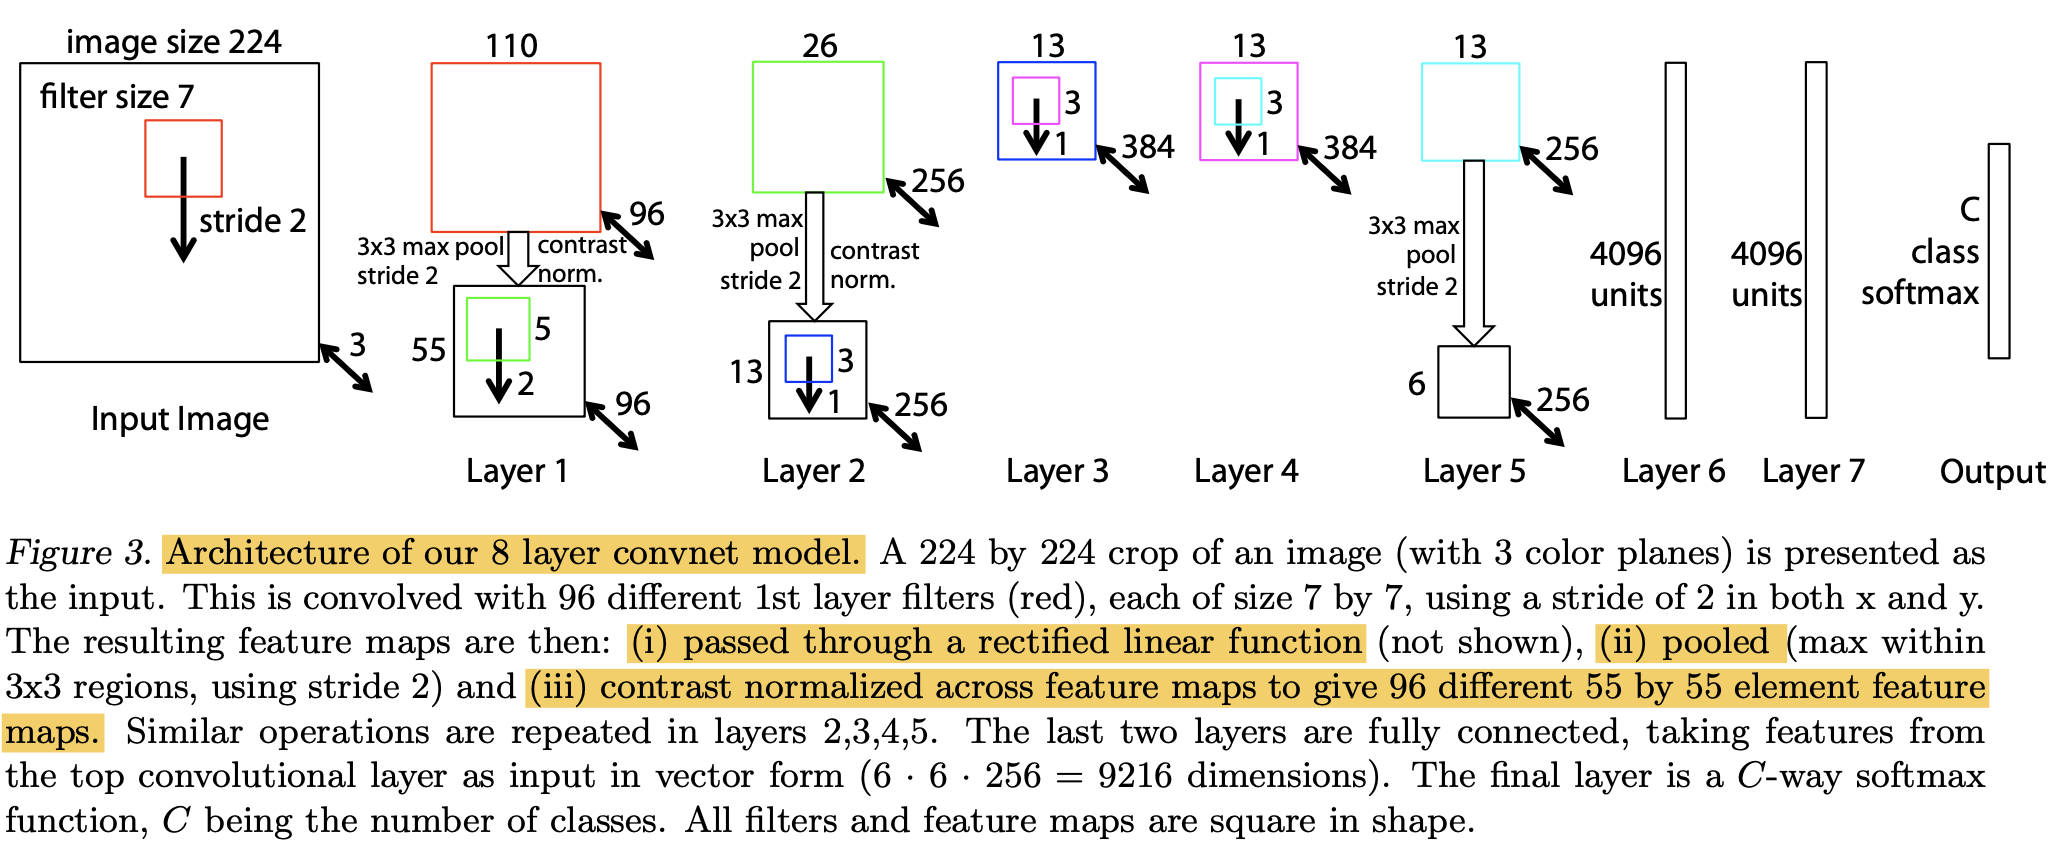

In [5]:
# Reference : https://github.com/arvention/ZFNet-PyTorch/blob/master/model.py
class ZFNet(nn.Module):
    def __init__(self, channels, num_cls):
        super(ZFNet, self).__init__()
        self.channels = channels
        self.num_cls = num_cls

        self.conv_net = self.get_conv_net()
        self.fc_net = self.get_fc_net()
    
    def get_conv_net(self):
        layers = []
        
        # in_channels = self.channels, out_channels = 96
        # kernel_size = 7 x 7, stride = 2
        layer = nn.Conv2d(self.channels, 96, kernel_size=7, stride=2, padding=1)
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.constant_(layer.bias, 0.0)
        layers.append(layer)
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        layers.append(nn.LocalResponseNorm(5))
        
        # in_channels = 96, out_channels = 256
        # kernel_size = 5 x 5, stride = 2
        layer = nn.Conv2d(96, 256, kernel_size=5, stride=2)
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.constant_(layer.bias, 0.0)
        layers.append(layer)
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        layers.append(nn.LocalResponseNorm(5))
        
        # in_channels = 256, out_channels = 384
        # kernel_size = 3 x 3, stride = 1
        layer = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.constant_(layer.bias, 0.0)
        layers.append(layer)
        layers.append(nn.ReLU(inplace=True))
        
        # in_channels = 384, out_channels = 384
        # kernel_size= 3 x 3, stride = 1
        layer = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.constant_(layer.bias, 0.0)
        layers.append(layer)
        layers.append(nn.ReLU(inplace=True))
        
        # in_channels = 384, out_channels = 256
        # kernel_size = 3 x 3, stride = 1
        layer = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.constant_(layer.bias, 0.0)
        layers.append(layer)
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(kernel_size=3, stride=2))
        
        return nn.Sequential(*layers)
    
    def get_fc_net(self):
        layers = []
        
        # in_channels = 9216 -> output of self.conv_net
        # out_channels = 4096
        layer = nn.Linear(9216, 4096)
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.constant_(layer.bias, 0.0)
        layers.append(layer)
        layers.append(nn.Dropout())
        
        # in_channels = 4096
        # out_channels = self.class_count
        layer = nn.Linear(4096, self.num_cls)
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.constant_(layer.bias, 0.0)
        layers.append(layer)
        layers.append(nn.Dropout())
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv_net(x)
        x = x.view(-1, 9216)
        x = self.fc_net(x)

        return x

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ZFNet(channels=3, num_cls=10).to(device)
print(model)

ZFNet(
  (conv_net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_net): Sequential(
    (0): Linear(in_features=9216, out_features=4096, 

# Training and Test
---
## Loss Function, Optimizer, and Scheduler

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.9
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=5,
    verbose=True
)

## Training Function

In [8]:

def train(dataloader, model, loss_fn, optimizer, scheduler, device):
    total_nums = len(dataloader.dataset)
    model.train()
    
    losses = []
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        preds = model(images)
        loss = loss_fn(preds, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, cur_nums = loss.item(), batch * len(images)
            print(f'loss: {loss:>7f} [{cur_nums:>5d}/{total_nums:>5d}]')
        
    scheduler.step(loss)
        
    return sum(losses)/len(losses)

## Test Function

In [9]:
def test(dataloader, model, loss_fn, device):
    total_nums = len(dataloader.dataset)
    batch_nums = len(dataloader)
    model.eval()
    test_loss, corrects = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            test_loss += loss_fn(preds, labels).item()
            corrects += (preds.argmax(1) == labels).type(torch.float).sum().item()

        test_loss /= batch_nums
        acc = corrects / total_nums * 100
        print(f'Test Error:\n Accuracy: {acc:>0.1f}%, Avg Loss: {test_loss:>8f}\n')
    return test_loss, acc

## Training and Test

In [10]:
epochs, results = 50, defaultdict(list)
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    print('-' * 30)
    train_loss = train(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss, test_acc = test(test_dataloader, model, loss_fn, device)
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
    
print('Done.')

Epoch 1:
------------------------------
loss: 2.504238 [    0/50000]
loss: 2.062431 [ 6400/50000]
loss: 1.853819 [12800/50000]
loss: 1.862063 [19200/50000]
loss: 1.891409 [25600/50000]
loss: 1.943128 [32000/50000]
loss: 1.871993 [38400/50000]
loss: 1.997693 [44800/50000]
Test Error:
 Accuracy: 47.5%, Avg Loss: 1.650165

Epoch 2:
------------------------------
loss: 1.883826 [    0/50000]
loss: 1.810328 [ 6400/50000]
loss: 1.683363 [12800/50000]
loss: 1.774267 [19200/50000]
loss: 1.761576 [25600/50000]
loss: 1.780320 [32000/50000]
loss: 1.795801 [38400/50000]
loss: 1.720669 [44800/50000]
Test Error:
 Accuracy: 62.1%, Avg Loss: 1.252279

Epoch 3:
------------------------------
loss: 1.748682 [    0/50000]
loss: 1.739870 [ 6400/50000]
loss: 1.597446 [12800/50000]
loss: 1.835675 [19200/50000]
loss: 1.825443 [25600/50000]
loss: 1.666750 [32000/50000]
loss: 1.588987 [38400/50000]
loss: 1.690182 [44800/50000]
Test Error:
 Accuracy: 65.2%, Avg Loss: 1.129670

Epoch 4:
-------------------------

# Visualization
---

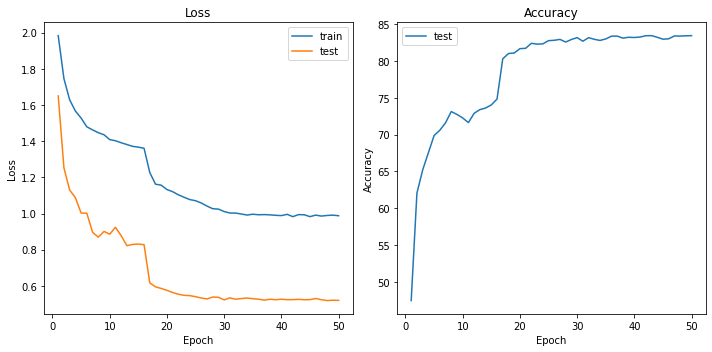

In [11]:
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
epoch_nums = range(1, epochs+1)

axis[0].plot(epoch_nums, results['train_loss'])
axis[0].plot(epoch_nums, results['test_loss'])
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].set_title('Loss')
axis[0].legend(['train', 'test'])

axis[1].plot(epoch_nums, results['test_acc'])
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
axis[1].set_title('Accuracy')
axis[1].legend(['test'])

plt.tight_layout()
plt.show()

# 회고
---
- ZFNet 논문에서는 LR을 수동으로 annealing했지만, 나는 `ReduceLROnPlateau`을 scheduler로 사용했음. 
- 유난히 구현에 참고할만한 Reference가 적었음. 
- CIFAR-10 dataset에 대해 batch_size=64, 50 Epoch 학습함. 

# Reference
---
- https://github.com/arvention/ZFNet-PyTorch
- https://stackoverflow.com/a/68123869
- https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
- https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/